Dataset link:

https://www.kaggle.com/balraj98/deepglobe-road-extraction-dataset

Installs

In [ ]:
pip install patchify

In [ ]:
pip install tensorflow-addons

In [ ]:
pip install focal-loss

#Imports

In [ ]:
import os
import cv2
# from PIL import Image, ImageDraw
import PIL.Image
import PIL.ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm

import json
import numpy as np

import tensorflow as tf
from tensorflow.keras import mixed_precision
import tensorflow_addons as tfa
import numpy as np
import gc
import random
from patchify import patchify, unpatchify
from focal_loss import BinaryFocalLoss

In [ ]:
#setting data type policy
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
IMG_WIDTH=256 
IMG_HEIGHT=256
IMG_CHANNELS=3


seed=25
np.random.seed=seed

In [ ]:
#trainset='train_1'

#Setting Paths

In [ ]:
train_path='/content/drive/MyDrive/takshak/train_final'
n_train_items=len(os.listdir(train_path))//2
print(n_train_items)

552


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#test path
takshak='/content/drive/MyDrive/takshak/takshak_test/Image'
n_data_test=10

Preprocessing data : trail 1

In [ ]:
# bluff_x=np.zeros((50*16,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
# bluff_y=np.zeros((50*16,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)

In [ ]:
# lst=os.listdir(train_path)
# lst.sort()

# i=0
# j=0
# for file in lst:
#     if i==50*16: break
#     filename = os.fsdecode(file)
#     if i%5==0: print(i, " files converted; ",50*16-i," to go " )
#     if filename.endswith('.jpg'):
#         img=cv2.imread(train_path+'/'+file,-1)
#         print("road image ",filename," of shape ",img.shape)

#         patches = patchify(img, (256, 256,3), step=256) 
#         for g in range(patches.shape[0]):
#           for h in range(patches.shape[1]):
#             single_patch = patches[g,h,:,:]
#             single_patch = (np.array(single_patch))
#             # single_patch = tf.keras.utils.normalize(np.array(single_patch))
#             # single_patch_input=np.expand_dims(single_patch_norm, 0)
#             bluff_x[i]=single_patch
#             print("for file ",i, " patch [",g,",",h,"] done")
#             i+=1
#     else:
#         img=cv2.imread(train_path+'/'+file,-1)
#         print("road image ",filename," of shape ",img.shape)

#         patches = patchify(img, (256, 256,3), step=256) 
#         for g in range(patches.shape[0]):
#           for h in range(patches.shape[1]):
#             single_patch = patches[g,h,:,:]
#             single_patch = (np.array(single_patch))
#             # single_patch = tf.keras.utils.normalize(np.array(single_patch))
#             # single_patch_input=np.expand_dims(single_patch_norm, 0)
#             bluff_y[j]=single_patch
#             print("for file ",j, " patch [",g,",",h,"] done")
#             j+=1


In [ ]:
# image_x=random.randint(0,50*16)
# print(image_x)
# plt.imshow(bluff_x[image_x])

In [ ]:
# plt.imshow(bluff_y[image_x])

#Processing Data : final

In [ ]:
train_x=np.zeros((n_train_items*16,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
# tf.cast(train_x,dtype=tf.bfloat16)
train_y=np.zeros((n_train_items*16,IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool)

In [ ]:
print(train_x.nbytes/(1024**2)+train_y.nbytes/(1024**2))

2208.0


In [ ]:
##########

## Train Data


lst=os.listdir(train_path)
lst.sort()

i=0
j=0
for file in lst:
    filename = os.fsdecode(file)
    if i%100==0: print(i, " files converted; ",n_train_items*16-i," to go " )
    if filename.endswith('.jpg'):
        img=cv2.imread(train_path+'/'+file,-1)
        print("road image ",filename," of shape ",img.shape)

        patches = patchify(img, (256, 256,3), step=256) 
        for g in range(patches.shape[0]):
          for h in range(patches.shape[1]):
            single_patch = patches[g,h,:,:]
            single_patch = (np.array(single_patch))
            # single_patch = tf.keras.utils.normalize(np.array(single_patch))
            # single_patch_input=np.expand_dims(single_patch_norm, 0)
            train_x[i]=single_patch
            print("for file ",i, " patch [",g,",",h,"] done")
            i+=1
    else:
        img=cv2.imread(train_path+'/'+file,-1)
        print("mask image ",filename," of shape ",img.shape)

        patches = patchify(img, (256, 256,1), step=256) 
        for g in range(patches.shape[0]):
          for h in range(patches.shape[1]):
            single_patch = patches[g,h,:,:]
            single_patch = (np.array(single_patch))
            # single_patch = tf.keras.utils.normalize(np.array(single_patch))
            # single_patch_input=np.expand_dims(single_patch_norm, 0)
            train_y[j]=single_patch
            print("for file ",j, " patch [",g,",",h,"] done")
            j+=1
del lst
gc.collect()
    
print("Done!")

8453


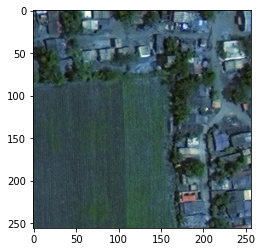

In [ ]:
image_x=random.randint(0,n_train_items*16)
print(image_x)
plt.imshow(train_x[image_x])

(256, 256, 3)


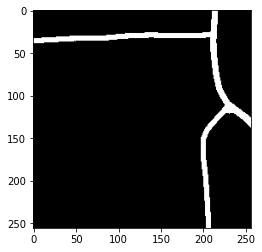

In [ ]:
a=train_y[image_x]*1
arrays=[a,a,a]
im=np.stack(arrays, axis=2).reshape((256, 256, 3))
print(im.shape)
plt.imshow(im*255)

# Model Building

In [ ]:
# Model
inputs=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
s=tf.keras.layers.Lambda(lambda x: x/255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
# outputs=tf.keras.layers.Conv2D(3,(1,1),activation='sigmoid')(c9)
outputs=tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

model=tf.keras.Model(inputs=[inputs],outputs=[outputs])
# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.compile(optimizer='adam',loss=BinaryFocalLoss(gamma=2),metrics=['accuracy'])
model.summary()






Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
#model checkpoints
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_roads.h5',verbose=1,save_best_only=True)
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]

results=model.fit(train_x,train_y,validation_split=0.1,batch_size=128,epochs=25,callbacks=callbacks)

Epoch 1/25
63/63 [==============================] - 195s 2s/step - loss: 0.0753 - accuracy: 0.9292 - val_loss: 0.0627 - val_accuracy: 0.9361
Epoch 2/25
63/63 [==============================] - 139s 2s/step - loss: 0.0637 - accuracy: 0.9315 - val_loss: 0.0615 - val_accuracy: 0.9361
Epoch 3/25
63/63 [==============================] - 138s 2s/step - loss: 0.0627 - accuracy: 0.9315 - val_loss: 0.0581 - val_accuracy: 0.9361
Epoch 4/25
63/63 [==============================] - 136s 2s/step - loss: 0.0601 - accuracy: 0.9315 - val_loss: 0.0579 - val_accuracy: 0.9361
Epoch 5/25
63/63 [==============================] - 137s 2s/step - loss: 0.0574 - accuracy: 0.9315 - val_loss: 0.0506 - val_accuracy: 0.9361
Epoch 6/25
63/63 [==============================] - 138s 2s/step - loss: 0.0500 - accuracy: 0.9322 - val_loss: 0.0456 - val_accuracy: 0.9391
Epoch 7/25
63/63 [==============================] - 136s 2s/step - loss: 0.0438 - accuracy: 0.9403 - val_loss: 0.0427 - val_accuracy: 0.9406
Epoch 8/25
63

In [ ]:
# len(train_x[:int(train_x.shape[0]*0.9)])

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       train_x:  1.6 GiB
                       train_y: 552.0 MiB
                           img:  3.0 MiB
                             a: 512.1 KiB
                  single_patch: 192.1 KiB
                          _iii:  3.6 KiB
                          _i33:  3.6 KiB
                          _i24:  1.5 KiB
                          _i29:  1.5 KiB
               BinaryFocalLoss:  1.2 KiB


## sanity check

In [ ]:
idx = random.randint(0, n_train_items*16)


preds_train = model.predict(train_x[:int(train_x.shape[0]*0.9)], verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
del preds_train
gc.collect()

249/249 [==============================] - 49s 190ms/step


2401

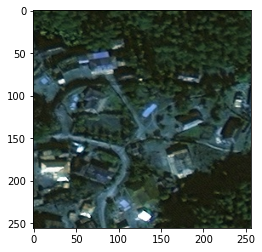

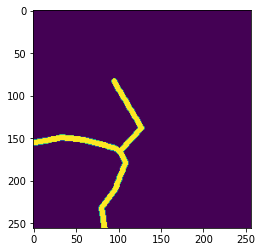

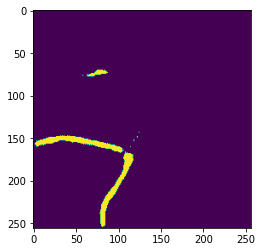

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, n_train_items*16)
plt.imshow(train_x[ix])
plt.show()
plt.imshow(np.squeeze(train_y[ix]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
preds_val = model.predict(train_x[int(train_x.shape[0]*0.9):], verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
del preds_val
gc.collect()

28/28 [==============================] - 7s 248ms/step


7763

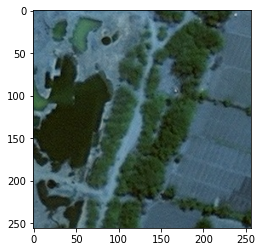

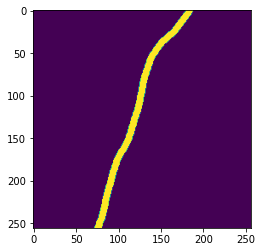

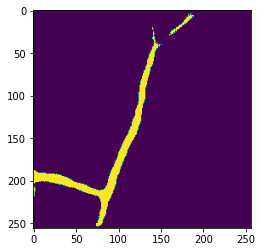

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
plt.imshow(train_x[int(train_x.shape[0]*0.9):][ix])
plt.show()
plt.imshow(np.squeeze(train_y[int(train_y.shape[0]*0.9):][ix]))
plt.show()
plt.imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [ ]:
preds_test = model.predict(train_x, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
del preds_test
gc.collect()

276/276 [==============================] - 53s 191ms/step


7704

In [ ]:
del train_x
del train_y
gc.collect()

50

#Tensorboard checkup

In [ ]:
!tensorboard --logdir=logs/ --host localhost --port 8088

2021-10-02 17:36:22.860264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-02 17:36:22.915033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-02 17:36:22.915437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.6.0 at http://localhost:8088/ (Press CTRL+C to quit)
^C


#Tracer

In [ ]:
def make_step(a,m,k):
  for i in range(len(m)):
    for j in range(len(m[i])):
      if m[i][j] == k:
        if i>0 and m[i-1][j] == 0 and a[i-1][j] == 0:
          m[i-1][j] = k + 1
        if j>0 and m[i][j-1] == 0 and a[i][j-1] == 0:
          m[i][j-1] = k + 1
        if i<len(m)-1 and m[i+1][j] == 0 and a[i+1][j] == 0:
          m[i+1][j] = k + 1
        if j<len(m[i])-1 and m[i][j+1] == 0 and a[i][j+1] == 0:
           m[i][j+1] = k + 1
  return m
def trace(startx,starty,endx,endy,a,m):
  k = 0
  while m[endx][endy] == 0:
      k += 1
      make_step(a,m,k)
    
  i, j = endx,endy
  k = m[i][j]
  the_path = [(i,j)]
  while k > 1:
    if i > 0 and m[i - 1][j] == k-1:
      i, j = i-1, j
      the_path.append((i, j))
      k-=1
    elif j > 0 and m[i][j - 1] == k-1:
      i, j = i, j-1
      the_path.append((i, j))
      k-=1
    elif i < len(m) - 1 and m[i + 1][j] == k-1:
      i, j = i+1, j
      the_path.append((i, j))
      k-=1
    elif j < len(m[i]) - 1 and m[i][j + 1] == k-1:
      i, j = i, j+1
      the_path.append((i, j))
      k -= 1
  return the_path



# Test Data and results

In [ ]:
patch_size=256

In [ ]:
def pred(model,image,patch_size=256):
    segm_img=np.zeros(image.shape[:2])
    patch_num=1
    for g in range(0,image.shape[0],256):
        for h in range(0,image.shape[1],256):
#             print('Image [',g,h,']')
            single_patch=img[g:g+patch_size,h:h+patch_size]
#             plt.imshow(np.array(single_patch))
            # single_patch=single_patch/255
            single_patch_shape = single_patch.shape[:2]
            single_patch_input = np.expand_dims(single_patch, 0)

            single_patch_prediction = model.predict(single_patch_input)
            single_patch_prediction=(single_patch_prediction[0,:,:,0] > .35).astype(np.uint8)
            segm_img[g:g+single_patch_shape[0], h:h+single_patch_shape[1]] += cv2.resize(single_patch_prediction, single_patch_shape[::-1])
            print('patch no= ',patch_num,'from index [',g,',',g+256,'] by [',h,',',h+256,']done')
            patch_num+=1
            ###
            
            # plt.imshow(np.array(single_patch))
            # plt.show()
            # plt.imshow(np.array(single_patch_prediction))
            # plt.show()

            ###
            
    print('Image no ', i+1, 'done')      
    return segm_img

Final shape=  (768, 1536, 3)
patch no=  1 from index [ 0 , 256 ] by [ 0 , 256 ]done
patch no=  2 from index [ 0 , 256 ] by [ 256 , 512 ]done
patch no=  3 from index [ 0 , 256 ] by [ 512 , 768 ]done
patch no=  4 from index [ 0 , 256 ] by [ 768 , 1024 ]done
patch no=  5 from index [ 0 , 256 ] by [ 1024 , 1280 ]done
patch no=  6 from index [ 0 , 256 ] by [ 1280 , 1536 ]done
patch no=  7 from index [ 256 , 512 ] by [ 0 , 256 ]done
patch no=  8 from index [ 256 , 512 ] by [ 256 , 512 ]done
patch no=  9 from index [ 256 , 512 ] by [ 512 , 768 ]done
patch no=  10 from index [ 256 , 512 ] by [ 768 , 1024 ]done
patch no=  11 from index [ 256 , 512 ] by [ 1024 , 1280 ]done
patch no=  12 from index [ 256 , 512 ] by [ 1280 , 1536 ]done
patch no=  13 from index [ 512 , 768 ] by [ 0 , 256 ]done
patch no=  14 from index [ 512 , 768 ] by [ 256 , 512 ]done
patch no=  15 from index [ 512 , 768 ] by [ 512 , 768 ]done
patch no=  16 from index [ 512 , 768 ] by [ 768 , 1024 ]done
patch no=  17 from index [ 

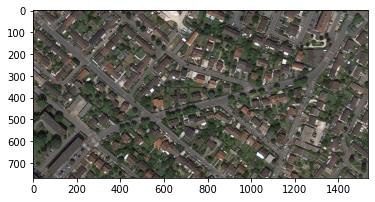

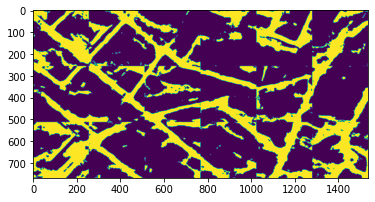

Final shape=  (1024, 1536, 3)
patch no=  1 from index [ 0 , 256 ] by [ 0 , 256 ]done
patch no=  2 from index [ 0 , 256 ] by [ 256 , 512 ]done
patch no=  3 from index [ 0 , 256 ] by [ 512 , 768 ]done
patch no=  4 from index [ 0 , 256 ] by [ 768 , 1024 ]done
patch no=  5 from index [ 0 , 256 ] by [ 1024 , 1280 ]done
patch no=  6 from index [ 0 , 256 ] by [ 1280 , 1536 ]done
patch no=  7 from index [ 256 , 512 ] by [ 0 , 256 ]done
patch no=  8 from index [ 256 , 512 ] by [ 256 , 512 ]done
patch no=  9 from index [ 256 , 512 ] by [ 512 , 768 ]done
patch no=  10 from index [ 256 , 512 ] by [ 768 , 1024 ]done
patch no=  11 from index [ 256 , 512 ] by [ 1024 , 1280 ]done
patch no=  12 from index [ 256 , 512 ] by [ 1280 , 1536 ]done
patch no=  13 from index [ 512 , 768 ] by [ 0 , 256 ]done
patch no=  14 from index [ 512 , 768 ] by [ 256 , 512 ]done
patch no=  15 from index [ 512 , 768 ] by [ 512 , 768 ]done
patch no=  16 from index [ 512 , 768 ] by [ 768 , 1024 ]done
patch no=  17 from index [

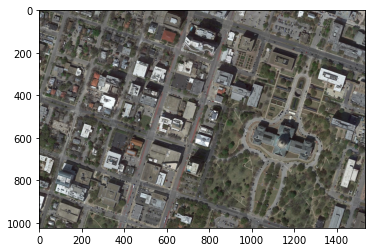

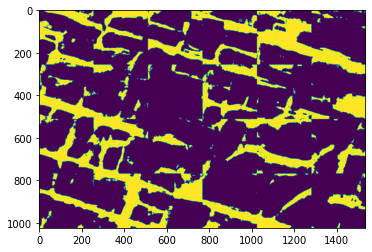

Final shape=  (768, 1536, 3)
patch no=  1 from index [ 0 , 256 ] by [ 0 , 256 ]done
patch no=  2 from index [ 0 , 256 ] by [ 256 , 512 ]done
patch no=  3 from index [ 0 , 256 ] by [ 512 , 768 ]done
patch no=  4 from index [ 0 , 256 ] by [ 768 , 1024 ]done
patch no=  5 from index [ 0 , 256 ] by [ 1024 , 1280 ]done
patch no=  6 from index [ 0 , 256 ] by [ 1280 , 1536 ]done
patch no=  7 from index [ 256 , 512 ] by [ 0 , 256 ]done
patch no=  8 from index [ 256 , 512 ] by [ 256 , 512 ]done
patch no=  9 from index [ 256 , 512 ] by [ 512 , 768 ]done
patch no=  10 from index [ 256 , 512 ] by [ 768 , 1024 ]done
patch no=  11 from index [ 256 , 512 ] by [ 1024 , 1280 ]done
patch no=  12 from index [ 256 , 512 ] by [ 1280 , 1536 ]done
patch no=  13 from index [ 512 , 768 ] by [ 0 , 256 ]done
patch no=  14 from index [ 512 , 768 ] by [ 256 , 512 ]done
patch no=  15 from index [ 512 , 768 ] by [ 512 , 768 ]done
patch no=  16 from index [ 512 , 768 ] by [ 768 , 1024 ]done
patch no=  17 from index [ 

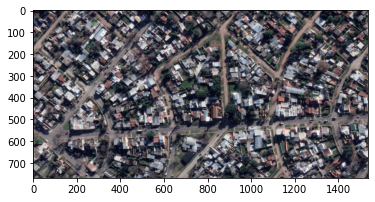

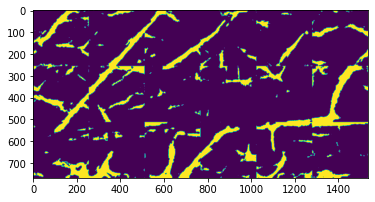

Final shape=  (1024, 1536, 3)
patch no=  1 from index [ 0 , 256 ] by [ 0 , 256 ]done
patch no=  2 from index [ 0 , 256 ] by [ 256 , 512 ]done
patch no=  3 from index [ 0 , 256 ] by [ 512 , 768 ]done
patch no=  4 from index [ 0 , 256 ] by [ 768 , 1024 ]done
patch no=  5 from index [ 0 , 256 ] by [ 1024 , 1280 ]done
patch no=  6 from index [ 0 , 256 ] by [ 1280 , 1536 ]done
patch no=  7 from index [ 256 , 512 ] by [ 0 , 256 ]done
patch no=  8 from index [ 256 , 512 ] by [ 256 , 512 ]done
patch no=  9 from index [ 256 , 512 ] by [ 512 , 768 ]done
patch no=  10 from index [ 256 , 512 ] by [ 768 , 1024 ]done
patch no=  11 from index [ 256 , 512 ] by [ 1024 , 1280 ]done
patch no=  12 from index [ 256 , 512 ] by [ 1280 , 1536 ]done
patch no=  13 from index [ 512 , 768 ] by [ 0 , 256 ]done
patch no=  14 from index [ 512 , 768 ] by [ 256 , 512 ]done
patch no=  15 from index [ 512 , 768 ] by [ 512 , 768 ]done
patch no=  16 from index [ 512 , 768 ] by [ 768 , 1024 ]done
patch no=  17 from index [

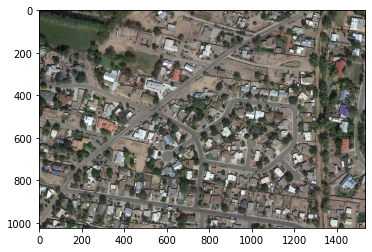

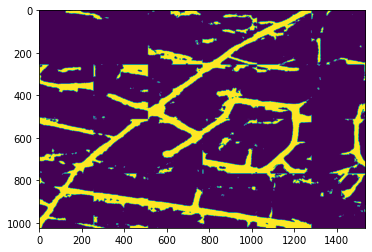

Final shape=  (768, 1792, 3)
patch no=  1 from index [ 0 , 256 ] by [ 0 , 256 ]done
patch no=  2 from index [ 0 , 256 ] by [ 256 , 512 ]done
patch no=  3 from index [ 0 , 256 ] by [ 512 , 768 ]done
patch no=  4 from index [ 0 , 256 ] by [ 768 , 1024 ]done
patch no=  5 from index [ 0 , 256 ] by [ 1024 , 1280 ]done
patch no=  6 from index [ 0 , 256 ] by [ 1280 , 1536 ]done
patch no=  7 from index [ 0 , 256 ] by [ 1536 , 1792 ]done
patch no=  8 from index [ 256 , 512 ] by [ 0 , 256 ]done
patch no=  9 from index [ 256 , 512 ] by [ 256 , 512 ]done
patch no=  10 from index [ 256 , 512 ] by [ 512 , 768 ]done
patch no=  11 from index [ 256 , 512 ] by [ 768 , 1024 ]done
patch no=  12 from index [ 256 , 512 ] by [ 1024 , 1280 ]done
patch no=  13 from index [ 256 , 512 ] by [ 1280 , 1536 ]done
patch no=  14 from index [ 256 , 512 ] by [ 1536 , 1792 ]done
patch no=  15 from index [ 512 , 768 ] by [ 0 , 256 ]done
patch no=  16 from index [ 512 , 768 ] by [ 256 , 512 ]done
patch no=  17 from index [

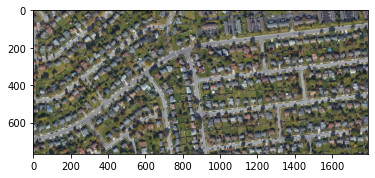

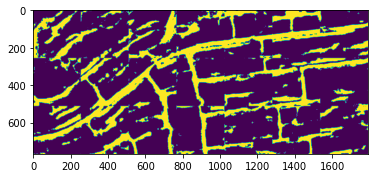

Final shape=  (768, 1536, 3)
patch no=  1 from index [ 0 , 256 ] by [ 0 , 256 ]done
patch no=  2 from index [ 0 , 256 ] by [ 256 , 512 ]done
patch no=  3 from index [ 0 , 256 ] by [ 512 , 768 ]done
patch no=  4 from index [ 0 , 256 ] by [ 768 , 1024 ]done
patch no=  5 from index [ 0 , 256 ] by [ 1024 , 1280 ]done
patch no=  6 from index [ 0 , 256 ] by [ 1280 , 1536 ]done
patch no=  7 from index [ 256 , 512 ] by [ 0 , 256 ]done
patch no=  8 from index [ 256 , 512 ] by [ 256 , 512 ]done
patch no=  9 from index [ 256 , 512 ] by [ 512 , 768 ]done
patch no=  10 from index [ 256 , 512 ] by [ 768 , 1024 ]done
patch no=  11 from index [ 256 , 512 ] by [ 1024 , 1280 ]done
patch no=  12 from index [ 256 , 512 ] by [ 1280 , 1536 ]done
patch no=  13 from index [ 512 , 768 ] by [ 0 , 256 ]done
patch no=  14 from index [ 512 , 768 ] by [ 256 , 512 ]done
patch no=  15 from index [ 512 , 768 ] by [ 512 , 768 ]done
patch no=  16 from index [ 512 , 768 ] by [ 768 , 1024 ]done
patch no=  17 from index [ 

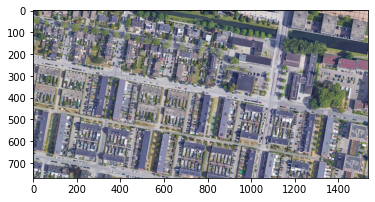

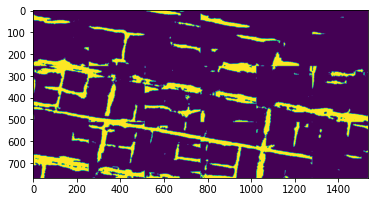

Final shape=  (768, 1536, 3)
patch no=  1 from index [ 0 , 256 ] by [ 0 , 256 ]done
patch no=  2 from index [ 0 , 256 ] by [ 256 , 512 ]done
patch no=  3 from index [ 0 , 256 ] by [ 512 , 768 ]done
patch no=  4 from index [ 0 , 256 ] by [ 768 , 1024 ]done
patch no=  5 from index [ 0 , 256 ] by [ 1024 , 1280 ]done
patch no=  6 from index [ 0 , 256 ] by [ 1280 , 1536 ]done
patch no=  7 from index [ 256 , 512 ] by [ 0 , 256 ]done
patch no=  8 from index [ 256 , 512 ] by [ 256 , 512 ]done
patch no=  9 from index [ 256 , 512 ] by [ 512 , 768 ]done
patch no=  10 from index [ 256 , 512 ] by [ 768 , 1024 ]done
patch no=  11 from index [ 256 , 512 ] by [ 1024 , 1280 ]done
patch no=  12 from index [ 256 , 512 ] by [ 1280 , 1536 ]done
patch no=  13 from index [ 512 , 768 ] by [ 0 , 256 ]done
patch no=  14 from index [ 512 , 768 ] by [ 256 , 512 ]done
patch no=  15 from index [ 512 , 768 ] by [ 512 , 768 ]done
patch no=  16 from index [ 512 , 768 ] by [ 768 , 1024 ]done
patch no=  17 from index [ 

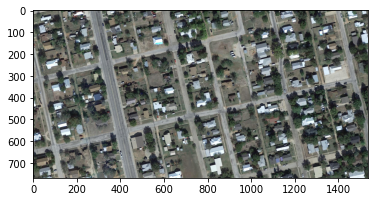

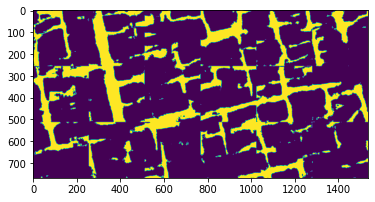

Final shape=  (768, 1536, 3)
patch no=  1 from index [ 0 , 256 ] by [ 0 , 256 ]done
patch no=  2 from index [ 0 , 256 ] by [ 256 , 512 ]done
patch no=  3 from index [ 0 , 256 ] by [ 512 , 768 ]done
patch no=  4 from index [ 0 , 256 ] by [ 768 , 1024 ]done
patch no=  5 from index [ 0 , 256 ] by [ 1024 , 1280 ]done
patch no=  6 from index [ 0 , 256 ] by [ 1280 , 1536 ]done
patch no=  7 from index [ 256 , 512 ] by [ 0 , 256 ]done
patch no=  8 from index [ 256 , 512 ] by [ 256 , 512 ]done
patch no=  9 from index [ 256 , 512 ] by [ 512 , 768 ]done
patch no=  10 from index [ 256 , 512 ] by [ 768 , 1024 ]done
patch no=  11 from index [ 256 , 512 ] by [ 1024 , 1280 ]done
patch no=  12 from index [ 256 , 512 ] by [ 1280 , 1536 ]done
patch no=  13 from index [ 512 , 768 ] by [ 0 , 256 ]done
patch no=  14 from index [ 512 , 768 ] by [ 256 , 512 ]done
patch no=  15 from index [ 512 , 768 ] by [ 512 , 768 ]done
patch no=  16 from index [ 512 , 768 ] by [ 768 , 1024 ]done
patch no=  17 from index [ 

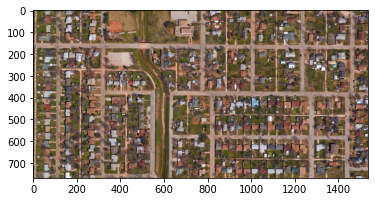

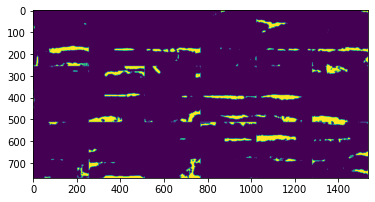

Final shape=  (768, 1792, 3)
patch no=  1 from index [ 0 , 256 ] by [ 0 , 256 ]done
patch no=  2 from index [ 0 , 256 ] by [ 256 , 512 ]done
patch no=  3 from index [ 0 , 256 ] by [ 512 , 768 ]done
patch no=  4 from index [ 0 , 256 ] by [ 768 , 1024 ]done
patch no=  5 from index [ 0 , 256 ] by [ 1024 , 1280 ]done
patch no=  6 from index [ 0 , 256 ] by [ 1280 , 1536 ]done
patch no=  7 from index [ 0 , 256 ] by [ 1536 , 1792 ]done
patch no=  8 from index [ 256 , 512 ] by [ 0 , 256 ]done
patch no=  9 from index [ 256 , 512 ] by [ 256 , 512 ]done
patch no=  10 from index [ 256 , 512 ] by [ 512 , 768 ]done
patch no=  11 from index [ 256 , 512 ] by [ 768 , 1024 ]done
patch no=  12 from index [ 256 , 512 ] by [ 1024 , 1280 ]done
patch no=  13 from index [ 256 , 512 ] by [ 1280 , 1536 ]done
patch no=  14 from index [ 256 , 512 ] by [ 1536 , 1792 ]done
patch no=  15 from index [ 512 , 768 ] by [ 0 , 256 ]done
patch no=  16 from index [ 512 , 768 ] by [ 256 , 512 ]done
patch no=  17 from index [

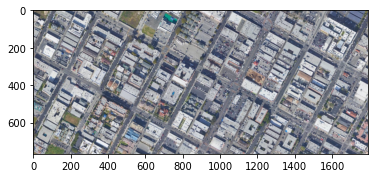

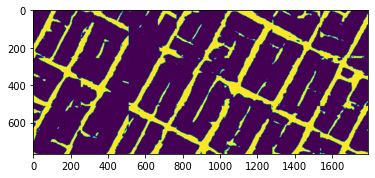

Final shape=  (768, 1536, 3)
patch no=  1 from index [ 0 , 256 ] by [ 0 , 256 ]done
patch no=  2 from index [ 0 , 256 ] by [ 256 , 512 ]done
patch no=  3 from index [ 0 , 256 ] by [ 512 , 768 ]done
patch no=  4 from index [ 0 , 256 ] by [ 768 , 1024 ]done
patch no=  5 from index [ 0 , 256 ] by [ 1024 , 1280 ]done
patch no=  6 from index [ 0 , 256 ] by [ 1280 , 1536 ]done
patch no=  7 from index [ 256 , 512 ] by [ 0 , 256 ]done
patch no=  8 from index [ 256 , 512 ] by [ 256 , 512 ]done
patch no=  9 from index [ 256 , 512 ] by [ 512 , 768 ]done
patch no=  10 from index [ 256 , 512 ] by [ 768 , 1024 ]done
patch no=  11 from index [ 256 , 512 ] by [ 1024 , 1280 ]done
patch no=  12 from index [ 256 , 512 ] by [ 1280 , 1536 ]done
patch no=  13 from index [ 512 , 768 ] by [ 0 , 256 ]done
patch no=  14 from index [ 512 , 768 ] by [ 256 , 512 ]done
patch no=  15 from index [ 512 , 768 ] by [ 512 , 768 ]done
patch no=  16 from index [ 512 , 768 ] by [ 768 , 1024 ]done
patch no=  17 from index [ 

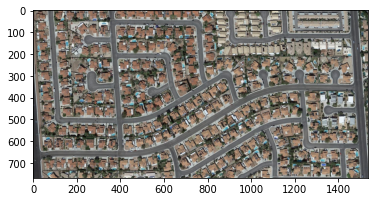

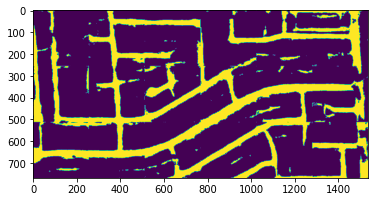

In [ ]:
# test_x=np.zeros((1024*1024*3, 1))
patch_size=256
for i in range(n_data_test):
    im_filepath=takshak+str(i+1)+".png"
    json_filepath=takshak+str(i+1)+".json"
    
    img=PIL.Image.open(im_filepath)
    
    ## try cmyk to rgb
    if img.mode!= ' RGB':
        img=img.convert('RGB')
    
    json_file=open(json_filepath)
    data=json.load(json_file)
    
    start_x=data['Start'][0]
    start_y=data['Start'][1]
    end_x=data['End'][0]
    end_y=data['End'][1]
    
#     print("Initial size= ",img.size)
#     print(start_x,start_y)
#     print(end_x,end_y)

    new_start_x=min(start_x,end_x)-128
    new_start_y=min(start_y,end_y)-128
    new_end_x=min(start_x,end_x)-128+1024
    new_end_y=min(start_y,end_y)-128+1024
    
#     img=img.crop((new_start_x,new_start_y,new_end_x, new_end_y))
    img=img.crop((0,0,(img.size[0]//256)*256, (img.size[1]//256)*256))

    
    img=np.array(img)
    print('Final shape= ',img.shape)
#     pix=pix.reshape((pix.shape[0]*pix.shape[1]*pix.shape[2],1))
    ######Draws start and ends###########
    
#     img1 = PIL.ImageDraw.Draw(img)
#     img1.ellipse((start_x-10,start_y-10,start_x+10,start_y+10), fill = 'red', outline ='red')
#     img1.ellipse((end_x-10,end_y-10,end_x+10,end_y+10), fill = 'blue', outline ='blue')
#     img.show()
    # model.load_weights('model_for_roads.h5')
    result=pred(model,img,patch_size)
    print(result.shape)
    plt.imshow(img)
    plt.show()


    # m=np.zeros(result.shape)
    # m[start_y][start_x]=1
    # path=trace(startx,starty,endx,endy,1-result,m)

    # for (p,q) in path:
    #   plt.scatter(p, q, size, c="r", marker="+") 


    plt.imshow(result)
    plt.show()

    



    # del result
    # gc.collect()


    
            

In [ ]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [ ]:
# del preds_test_t
# del preds_train_t
# del preds_val_t
# gc.collect()